# Libs

In [13]:
import os
import joblib
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score, root_mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from IPython.display import clear_output

# Code

## Config

In [14]:
# YFinace
TICKERS = 'DIS'
START_DATE = '2000-01-01'
END_DATE = '2025-02-01'

# Data
DAYS = 60
TEST_SIZE = 0.2
SEED = 42

# Model
DROPOUT_RATE = 0.2

# Train
EPOCHS = 50
BATCH_SIZE = 32

## Data

In [15]:
data = yf.download(tickers=TICKERS, start=START_DATE, end=END_DATE, multi_level_index=False)

[*********************100%***********************]  1 of 1 completed


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6309 entries, 2000-01-03 to 2025-01-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   6309 non-null   float64
 1   High    6309 non-null   float64
 2   Low     6309 non-null   float64
 3   Open    6309 non-null   float64
 4   Volume  6309 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 295.7 KB


In [17]:
data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,22.833179,22.880948,21.973353,22.355498,8402230
2000-01-04,24.170687,24.361760,22.928714,22.928714,16051191
2000-01-05,25.173819,25.317125,24.170688,24.170688,19823822
2000-01-06,24.170687,25.317124,24.170687,25.173818,7903193
2000-01-07,23.788544,24.552834,23.549702,24.170689,6773543


## Data Pre processor

In [18]:
data = data[['Open', 'High', 'Low', 'Volume', 'Close']]

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

x, y = [], []
for i in range(len(data_scaled) - DAYS - 1):
	x.append(data_scaled[i:(i + DAYS), :-1])
	y.append(data_scaled[i + DAYS, -1])

x, y = np.array(x), np.array(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, random_state=SEED)

## Model

In [29]:
model = Sequential([
    Input(shape=(DAYS, x_train.shape[2])),
    LSTM(units=50, return_sequences=True),
    Dropout(DROPOUT_RATE),
    LSTM(units=50, return_sequences=True),
    Dropout(DROPOUT_RATE),
    LSTM(units=50),
    Dropout(DROPOUT_RATE),
    Dense(units=1,  activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

## Train

In [30]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test), verbose=2)

157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - loss: 5.9994e-04 - mean_absolute_error: 0.0174 - val_loss: 1.4300e-04 - val_mean_absolute_error: 0.0073
Epoch 48/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - loss: 5.9131e-04 - mean_absolute_error: 0.0175 - val_loss: 1.3064e-04 - val_mean_absolute_error: 0.0068
Epoch 49/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - loss: 5.7892e-04 - mean_absolute_error: 0.0177 - val_loss: 2.4481e-04 - val_mean_absolute_error: 0.0106
Epoch 50/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - loss: 5.4602e-04 - mean_absolute_error: 0.0164 - val_loss: 1.2289e-04 - val_mean_absolute_error: 0.0066


## Predict

In [31]:
predictions = model.predict(x_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [32]:
predictions_aux = np.zeros((len(predictions), data.shape[1]))
predictions_aux[:, -1] = predictions.flatten()
predictions_real = scaler.inverse_transform(predictions_aux)[:,-1]

y_test_aux = np.zeros((len(predictions), data.shape[1]))
y_test_aux[:, -1] = y_test
y_test_real = scaler.inverse_transform(y_test_aux)[:,-1]

## Metrics

In [33]:
mse = mean_squared_error(y_test_real, predictions_real)
mae = mean_absolute_error(y_test_real, predictions_real)
r2 = r2_score(y_test_real, predictions_real)
mape = mean_absolute_percentage_error(y_test_real, predictions_real)
ev_score = explained_variance_score(y_test_real, predictions_real)
rmse = root_mean_squared_error(y_test_real, predictions_real)

print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'RMSE: {rmse}')
print(f'MSE: {mse}')
print(f'R2: {r2}')
print(f'EV: {ev_score}')

with open('metrics/score.txt', 'w') as file:
	file.write(f'Mean Absolute Error(MAE): {mae}\n')
	file.write(f'Mean Absolute Percentage Error(MAPE): {mape}%\n')
	file.write(f'Root Mean Squared Error(RMSE): {rmse}\n')
	file.write(f'Mean Squared Error(MSE): {mse}\n')
	file.write(f'R2: {r2}\n')
	file.write(f'EV: {ev_score}')

MAE: 1.2478260965783057
MAPE: 0.022314372635265534%
RMSE: 2.092221318801358
MSE: 4.3773900468468945
R2: 0.9978290236519727
EV: 0.9978348706281717


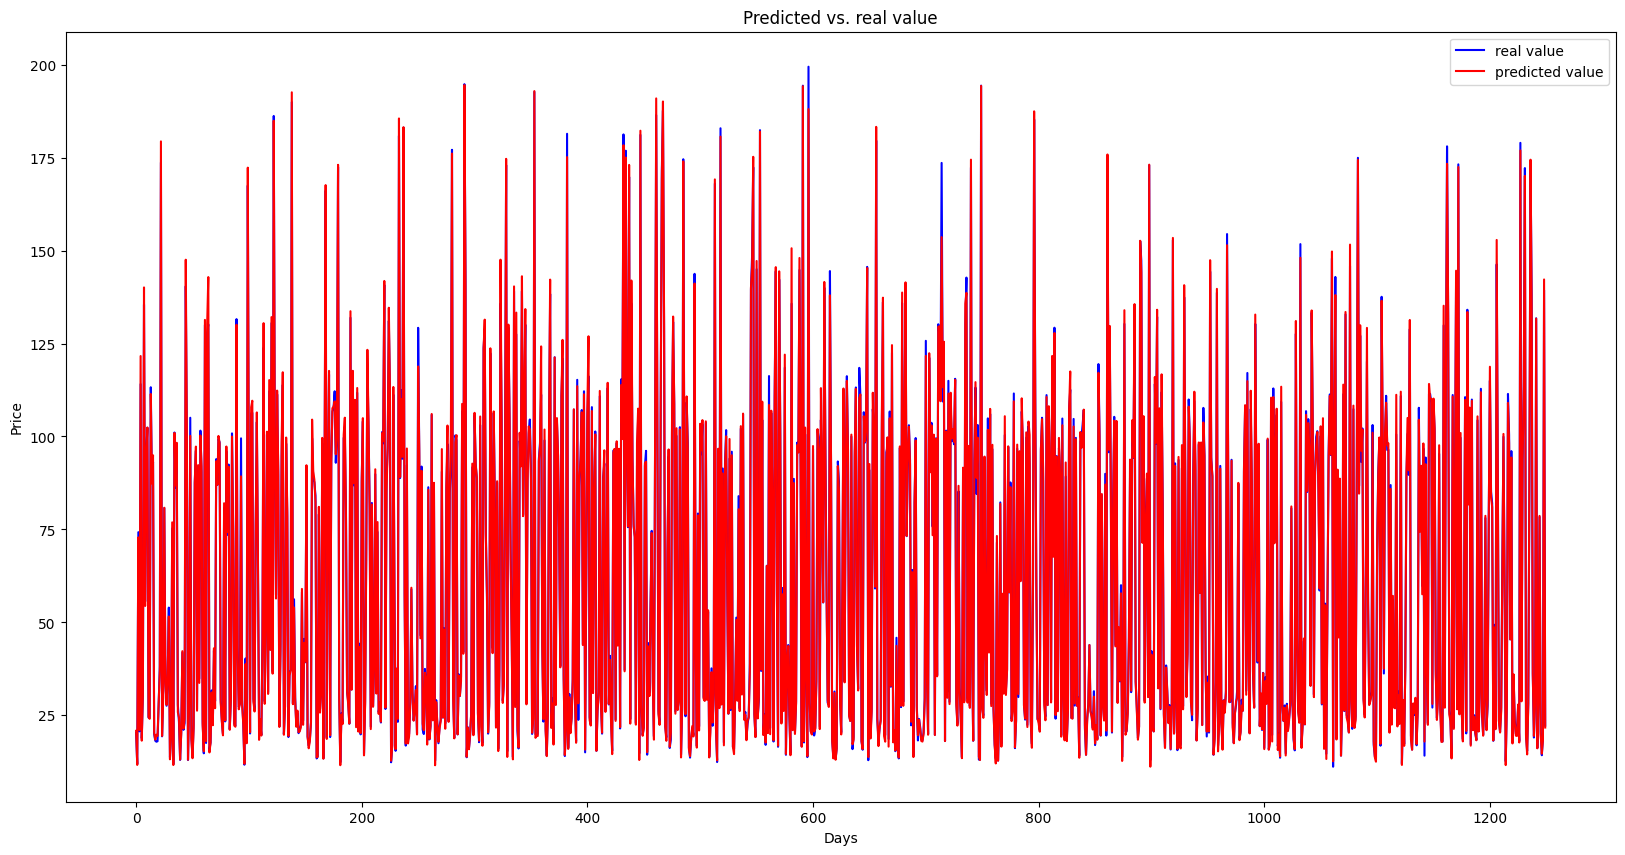

In [34]:
plt.figure(figsize=(20, 10))
plt.plot(y_test_real, color='blue', label='real value')
plt.plot(predictions_real, color='red', label='predicted value')
plt.title('Predicted vs. real value')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.savefig('./metrics/real_vs_predicted.png')
plt.show()

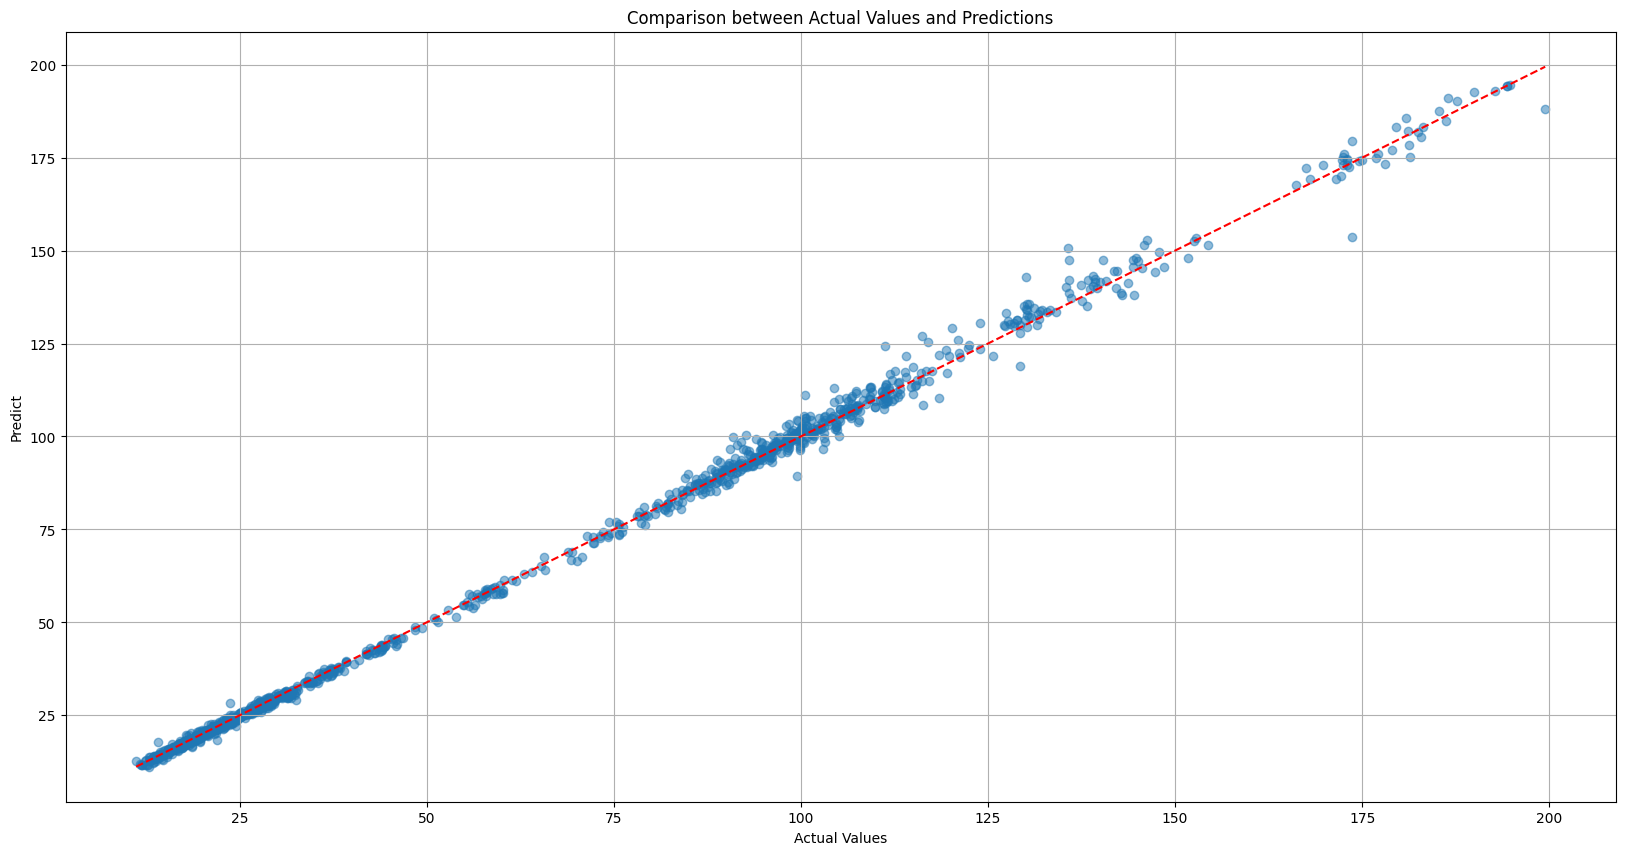

In [35]:
plt.figure(figsize=(20, 10))
plt.scatter(y_test_real, predictions_real, alpha=0.5)
plt.plot([min(y_test_real), max(y_test_real)], [min(y_test_real), max(y_test_real)], color='red', linestyle='--')
plt.title(f'Comparison between Actual Values and Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predict')
plt.grid(True)
plt.savefig('./metrics/scatter.png')
plt.show()

## Save model

In [36]:
model.save('model.keras')
joblib.dump(scaler, 'scaler.gz')

['scaler.gz']

# Update README

In [37]:
txt_file_path = "metrics/score.txt"
readme_path = "../README.md"

with open(txt_file_path, "r", encoding="utf-8") as file:
    content = file.read()

with open(readme_path, "r", encoding="utf-8") as file:
    readme_content = file.read()

start_marker = "<!-- START_SCORE -->"
end_marker = "<!-- END_SCORE -->"
new_section = f"{start_marker}\n```\n{content}\n```\n{end_marker}"

if start_marker in readme_content and end_marker in readme_content:
    updated_readme = readme_content.replace(
        readme_content[readme_content.find(start_marker):readme_content.find(end_marker) + len(end_marker)],
        new_section
    )
else:
    updated_readme = readme_content + "\n" + new_section

with open(readme_path, "w", encoding="utf-8") as file:
    file.write(updated_readme)

print("README updated successfully")

README updated successfully


In [38]:
clear_output(wait=True)